# Pytorch Practice: Classifying MNIST images

In this example, we will teach how to use Pytorch for a classic CV task: Classifying hand-written digits.  
We will cover the basics of Pytorch, including:

*   How to create loader for custom data
*   How to create an neural network
*   How to train a neural network
*   How to save the model
*   How to fine-tune a pre-trained model
*   How to debug the model

Reference: [CS231n](http://cs231n.stanford.edu/notebooks/pytorch_tutorial.ipynb)

## Download MNIST data

In [2]:
! wget -O mnist_png.tar.gz https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true
! tar zxf mnist_png.tar.gz

--2024-09-18 19:29:27--  https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/myleott/mnist_png/raw/refs/heads/master/mnist_png.tar.gz [following]
--2024-09-18 19:29:27--  https://github.com/myleott/mnist_png/raw/refs/heads/master/mnist_png.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/myleott/mnist_png/refs/heads/master/mnist_png.tar.gz [following]
--2024-09-18 19:29:27--  https://raw.githubusercontent.com/myleott/mnist_png/refs/heads/master/mnist_png.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443.

## Loading Pytorch module

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os
import numpy as np
from PIL import Image


## 1. Creating a custom dataset

PyTorch has many built-in datasets such as MNIST and CIFAR.  
In this tutorial, we demonstrate how to write your own dataset by implementing a custom MNIST dataset class.

In [4]:
class MNIST(Dataset):
    def __init__(self, root, transform=None):
        """ Intialize the MNIST dataset """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames: 10 class
        for i in range(10):
            filenames = glob.glob(os.path.join(root, str(i), '*.png'))
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label) pair

        self.len = len(self.filenames)

    def __getitem__(self, index):
        """ Get a sample from the dataset """
        image_fn, label = self.filenames[index]
        image = Image.open(image_fn)

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        """ Total number of samples in the dataset """
        return self.len

Let's load the images into custom-created Dataset.

In [5]:
# Create the MNIST dataset.
# transforms.ToTensor() automatically converts PIL images to
# torch tensors with range [0, 1]
trainset = MNIST(root='mnist_png/training',
    transform=transforms.ToTensor())

# load the testset
testset = MNIST(root='mnist_png/testing',
    transform=transforms.ToTensor())

print('# images in trainset:', len(trainset)) # Should print 60000
print('# images in testset:', len(testset)) # Should print 10000

# images in trainset: 60000
# images in testset: 10000


In [37]:
print(trainset[5000][0].size(),trainset[5000][1])

torch.Size([1, 28, 28]) 0


In Pytorch, the "DataLoader" class provides a simple way to collect data into batches.

In [6]:
# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)
testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

# get some random training images
dataiter = iter(trainset_loader)
# bug: see https://stackoverflow.com/questions/74289077/attributeerror-multiprocessingdataloaderiter-object-has-no-attribute-next
images, labels = next(dataiter)


print('Image tensor in each batch:', images.shape, images.dtype)
print('Label tensor in each batch:', labels.shape, labels.dtype)

Image tensor in each batch: torch.Size([64, 1, 28, 28]) torch.float32
Label tensor in each batch: torch.Size([64]) torch.int64


We can visualize what contains in each batch:

Labels:
tensor(1) tensor(0) tensor(0) tensor(1) tensor(9) tensor(1) tensor(9) tensor(1) tensor(9) tensor(5) tensor(0) tensor(8) tensor(0) tensor(1) tensor(1) tensor(0)


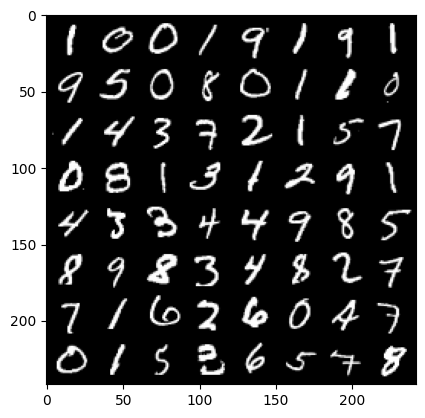

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:')
print(' '.join('%5s' % labels[j] for j in range(16)))

Let's check if GPU is available. If not, use CPU instead.

In [8]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print('Device used:', device)

Device used: cuda


## 2. Creating a Convolutional Neural Network

Pytorch uses "torch.nn.Module()" to wrap a neural network into a class object.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = Net().to(device) # Remember to move the model to "device"
print(model)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


## 3. Train the network

With the data loaded and network created, it's time to train the model!  
First, we define the training loop.

In [10]:
def test(model):
    criterion = nn.CrossEntropyLoss()
    model.eval()  # Important: set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad(): # This will free the GPU memory used for back-prop
        for data, target in testset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))

In [11]:
def train(model, epoch, log_interval=100):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    model.train()  # Important: set training mode

    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1

        test(model) # Evaluate at the end of each epoch

Remember to evaluate at the end of each epoch.

It's time to train the model!

In [53]:
# for batch_idx, (data, target) in enumerate(trainset_loader):
#     print(data.size())
#     print(target.size())
#     break
y=model(trainset[0][0].to(device))
loss=nn.CrossEntropyLoss()
output=loss(y,torch.tensor([trainset[0][1]]).to(device))
print(y, torch.tensor([trainset[0][1]]) )
print(output)

Tensor size and type after conv1: torch.Size([10, 12, 12]) torch.float32
Tensor size and type after conv2: torch.Size([20, 4, 4]) torch.float32
Tensor size and type after view(): torch.Size([1, 320]) torch.float32
Tensor size and type after fc1: torch.Size([1, 50]) torch.float32
Tensor size and type after fc2: torch.Size([1, 10]) torch.float32
tensor([[ 0.0021,  0.0159, -0.0844,  0.1803,  0.0634,  0.2452, -0.0116,  0.0871,
          0.0892, -0.0667]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([0])
tensor(2.3575, device='cuda:0', grad_fn=<NllLossBackward0>)


In [12]:
train(model, 5)  # train 5 epochs should get you to about 97% accuracy

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301372
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.295414
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.271077
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.251220
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.173775
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.102542
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.694222
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.589975
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.382355
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.973611

Test set: Average loss: 0.0007, Accuracy: 8177/10000 (82%)

Train Epoch: 1 [3968/60000 (7%)]	Loss: 0.362701
Train Epoch: 1 [10368/60000 (17%)]	Loss: 0.422391
Train Epoch: 1 [16768/60000 (28%)]	Loss: 0.302748
Train Epoch: 1 [23168/60000 (39%)]	Loss: 0.409735
Train Epoch: 1 [29568/60000 (49%)]	Loss: 0.224107
Train Epoch: 1 [35968/60000 (60%)]	Loss: 0.297871
Train Epoch: 1 [42368/60000 (71%)]	Loss: 0.362655
Train Epoch: 1 [48768/60000 (81%)]	Loss: 0.151734
Train Epoch: 1 [55168/60000 (92%)]	Loss: 0.1434

## 4. Save the model
Now we have a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk.

In [13]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

Define a training loop with model checkpointing:

In [14]:
def train_save(model, epoch, save_interval, log_interval=100):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    model.train()  # set training mode

    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test(model)

    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

Now, we can save the model in each iteration of training.

In [15]:
# create a brand new model
model = Net().to(device)
test(model)
train_save(model, 5, 500, 100)


Test set: Average loss: 0.0023, Accuracy: 1038/10000 (10%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.325348
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.298368
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.270430
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.231979
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.136256
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.910348
model saved to mnist-500.pth
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.461725
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.399091
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.265329
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.219235

Test set: Average loss: 0.0006, Accuracy: 8204/10000 (82%)

Train Epoch: 1 [3968/60000 (7%)]	Loss: 0.311161
model saved to mnist-1000.pth
Train Epoch: 1 [10368/60000 (17%)]	Loss: 0.287481
Train Epoch: 1 [16768/60000 (28%)]	Loss: 0.408251
Train Epoch: 1 [23168/60000 (39%)]	Loss: 0.315860
Train Epoch: 1 [29568/60000 (49%)]	Loss: 0.259721
Train Epoch: 1 [35968/60000 (60%)]	Loss: 0.205171
model saved to mnist-1500.p

Assume that we have stopped our training program.  
To load the saved model, we need to create the model and optimizer once again.  
Then we load the model weight and optimizer.

In [16]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# load from the final checkpoint
load_checkpoint('mnist-4690.pth', model, optimizer)

# should give you the final model accuracy
test(model)

model loaded from mnist-4690.pth


/tmp/ipykernel_32141/3486358145.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(checkpoint_path)



Test set: Average loss: 0.0001, Accuracy: 9633/10000 (96%)



## 5. Fine-tuning a pre-trained model

Sometimes you want to fine-tune a pretrained model instead of training a model from scratch. For example, if you want to train a model on a new dataset that contains natural images. To achieve the best performance, you can start with a model that's fully trained on ImageNet and fine-tune the model.

Finetuning a model in PyTorch is super easy! First, let's find out what we saved in a checkpoint:

In [17]:
# What's in a state dict?
print(model.state_dict().keys())

odict_keys(['conv1.0.weight', 'conv1.0.bias', 'conv2.0.weight', 'conv2.0.bias', 'fc1.0.weight', 'fc1.0.bias', 'fc2.weight', 'fc2.bias'])


Now say we want to load the conv layers from the checkpoint and train the fc layers. We can simply load a subset of the state dict with the selected names

In [18]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model = Net().to(device)
model_state = model.state_dict()
model_state.update(states_to_load)
model.load_state_dict(model_state)

/tmp/ipykernel_32141/551013859.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('mnist-4690.pth')


<All keys matched successfully>

Let's see how is the fine-tuning result.

In [19]:
train(model, 1)  # training 1 epoch will get you to 93%!

Train Epoch: 0 [0/60000 (0%)]	Loss: 3.474110
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.529166
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.148567
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.894542
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.779044
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.746305
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.833176
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.547904
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.619920
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.699415

Test set: Average loss: 0.0003, Accuracy: 9218/10000 (92%)



We can even use the pretrained conv layers in a different model.

In [20]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        return x

model = SmallNet().to(device)
print(model)

SmallNet(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (fc1): Linear(in_features=320, out_features=10, bias=True)
)


In [21]:
# 1. load the entired pretrained model(checkpoint)
# 2. select the desired layers(parameters)
# 3. update the new model with the selected part of pretrained model
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)

model.load_state_dict(model_state)

/tmp/ipykernel_32141/3582524739.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('mnist-4690.pth')


<All keys matched successfully>

In [22]:
train(model, 1)  # training 1 epoch will get you to 93%!

Train Epoch: 0 [0/60000 (0%)]	Loss: 4.409426
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.636736
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.443060
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.394373
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.328794
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.466223
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.436625
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.287042
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.182870
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.152446

Test set: Average loss: 0.0002, Accuracy: 9484/10000 (95%)



## 6. How to debug the model?

Debugging in Pytorch is quite simple.  
**"Check your tensor shape and data type constantly."**  
For example, if we want to visualize the tensor blob when forwarding the model:

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        print('Tensor size and type after conv1:', x.shape, x.dtype)
        x = self.conv2(x)
        print('Tensor size and type after conv2:', x.shape, x.dtype)
        x = x.view(-1, 320)
        print('Tensor size and type after view():', x.shape, x.dtype)
        x = self.fc1(x)
        print('Tensor size and type after fc1:', x.shape, x.dtype)
        x = self.fc2(x)
        print('Tensor size and type after fc2:', x.shape, x.dtype)
        return x

model = Net().to(device) # Remember to move the model to "device"

In [24]:
# Fowarding a dummy tensor
x = torch.Tensor(64,1,28,28).to(device) # shape of N*C*H*W
x = model(x)

Tensor size and type after conv1: torch.Size([64, 10, 12, 12]) torch.float32
Tensor size and type after conv2: torch.Size([64, 20, 4, 4]) torch.float32
Tensor size and type after view(): torch.Size([64, 320]) torch.float32
Tensor size and type after fc1: torch.Size([64, 50]) torch.float32
Tensor size and type after fc2: torch.Size([64, 10]) torch.float32
